# 🧠 Brain Tumor MRI Classification Using Deep Learning

## 📘 Introduction

Brain tumors are abnormal growths of tissue in the brain that can be either benign (non-cancerous) or malignant (cancerous). Due to the rigidity of the skull, any abnormal mass can lead to increased intracranial pressure, potentially resulting in brain damage or death. Therefore, **early detection and accurate classification of brain tumors** are critical for improving treatment outcomes and saving lives.

This project aims to leverage **Convolutional Neural Networks (CNNs)** to classify brain MRI scans into four categories:

- **Glioma**
- **Meningioma**
- **Pituitary tumor**
- **No tumor**

By applying deep learning techniques to this medical imaging problem, we contribute to the growing field of AI-assisted diagnosis, providing scalable and accurate diagnostic support to healthcare professionals.

## 🧪 Objective

- Perform **image classification** on brain MRI scans using CNNs
- Accurately distinguish between tumor types and healthy cases
- Explore data preprocessing techniques to improve model accuracy
- Lay the groundwork for future expansion into segmentation or malignancy grading tasks

## 📂 About the Dataset

This project uses a publicly available brain MRI dataset that combines images from the following sources:

- **Figshare**
- **SARTAJ**
- **Br35H**

The dataset consists of **7023 brain MRI images** classified into four categories: `glioma`, `meningioma`, `pituitary`, and `no tumor`. The image sizes vary and require preprocessing and resizing to standard dimensions for CNN input.

> ⚠️ *Note from the dataset author: The glioma class from the SARTAJ dataset was found to be misclassified. These were removed and replaced with correctly labeled images from the Figshare dataset.*

## 🙏 Dataset Credits

Dataset provided by [Masoud Nickparvar](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) on Kaggle.  
If you find this dataset helpful, consider upvoting the original [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

---

*This notebook is part of a research-inspired project to explore the application of CNNs in brain tumor detection using MRI data.*


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded') 

modules loaded


## 📁 2. Loading and Structuring the Dataset

In this section, we programmatically scan through the dataset directory structure and build a DataFrame that contains the full file paths of all MRI images along with their corresponding set (`Training` or `Testing`) and class labels.

The dataset is organized as follows:

- `archive/`
  - `Training/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`
  - `Testing/`
    - `glioma/`
    - `meningioma/`
    - `notumor/`
    - `pituitary/`

To prepare the data for analysis and modeling, we:
- Loop through both the `Training` and `Testing` folders.
- Extract the full file paths of images with valid extensions (`.jpg`, `.png`, `.jpeg`).
- Normalize the class labels by converting them to lowercase.
- Store everything in a structured DataFrame with the following columns:
  - `filepaths`: full path to the image file
  - `set`: either `"Training"` or `"Testing"`
  - `class`: one of `"glioma"`, `"meningioma"`, `"notumor"`, or `"pituitary"`

We'll use this DataFrame to perform EDA, visualization, and feed the images into our CNN model later on.


In [34]:
import os
import pandas as pd

# Set the base path to your dataset
base_dir = r'C:./archive'

filepaths = []
sets = []
classes = []

# Loop through Training and Testing directories
for split in ['Training', 'Testing']:
    split_path = os.path.join(base_dir, split)
    
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        
        if not os.path.isdir(class_path):
            continue
        
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(class_path, img_file)
                filepaths.append(full_path)
                sets.append(split)
                classes.append(class_folder.lower().strip())

# Create DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'set': sets,
    'class': classes
})


# Previewb
print(df.head())



                                      filepaths       set   class
0  C:./archive\Training\glioma\Tr-glTr_0000.jpg  Training  glioma
1  C:./archive\Training\glioma\Tr-glTr_0001.jpg  Training  glioma
2  C:./archive\Training\glioma\Tr-glTr_0002.jpg  Training  glioma
3  C:./archive\Training\glioma\Tr-glTr_0003.jpg  Training  glioma
4  C:./archive\Training\glioma\Tr-glTr_0004.jpg  Training  glioma


In [33]:
# Check number of samples per set
print("Samples per set:")
print(df['set'].value_counts(), "\n")

# Check number of samples per class
print("Samples per class:")
print(df['class'].value_counts(), "\n")

# Check number of samples per class per set
print("Samples per class per set:")
print(df.groupby(['set', 'class']).size())


Samples per set:
set
Training    5712
Testing     1311
Name: count, dtype: int64 

Samples per class:
class
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64 

Samples per class per set:
set       class     
Testing   glioma         300
          meningioma     306
          notumor        405
          pituitary      300
Training  glioma        1321
          meningioma    1339
          notumor       1595
          pituitary     1457
dtype: int64


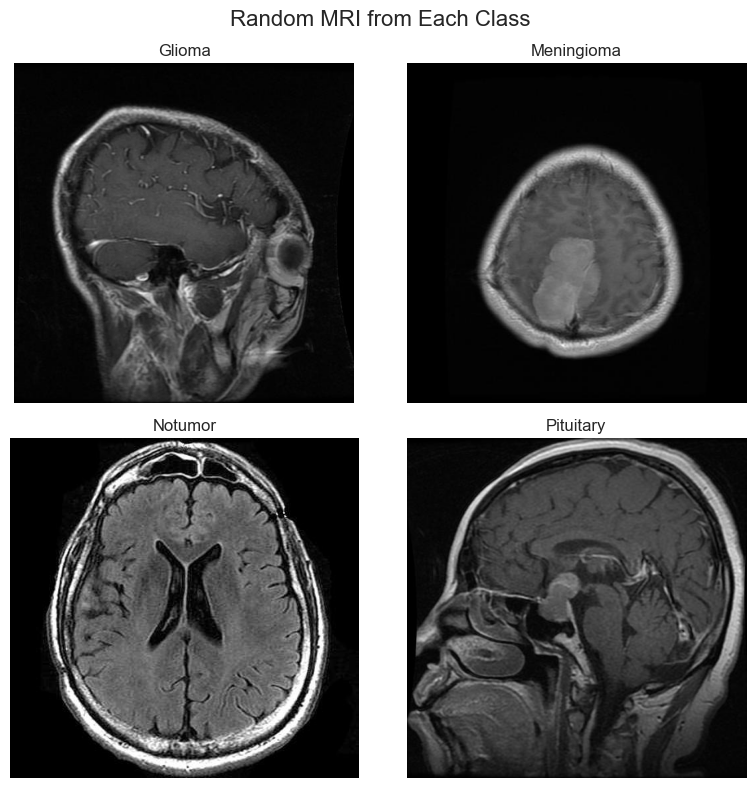

In [36]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Sample one random image per class
sample_df = df.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Plot images in a 2x2 grid
plt.figure(figsize=(8, 8))

for i, row in sample_df.iterrows():
    img = Image.open(row['filepaths'])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(row['class'].capitalize())
    plt.axis('off')

plt.suptitle("Random MRI from Each Class", fontsize=16)
plt.tight_layout()
plt.show()
